# Flux Computational Workshop 17 September 2021
## Computational modeling of goal-directed and habitual reinforcement-learning strategies

Claire Smid<sup>1</sup> and Wouter Kool<sup>2</sup><br>
<sub><sup>1</sup> University College London<br>
<sup>2</sup> Washington University in St. Louis<br></sub>

### Workshop Step 3: Goal and Purpose

In the previous section, you successfully implemented a  model that could perform the two-step task by using either model-free control, model-based control, or a _mixture_ of both.

The main reason research have developed these mixture models, is to use them to explain human behavior on this task. In order to do that, you need to first recruit a bunch of participants to perform a task like the one we just described. Then, you can fit the computational model to each participant's data. This results in a set of values for each parameter in the model (i.e., $w$, $\alpha$, $\beta$), that best describe the data. In other words, you can use model-fitting to infer _how_ model-based a participant was, _how_ high their learning rate was, and _how_ 'greedy' (high inverse temperature) or _how_ 'explorative' (low inverse temperature) they where.

Most computational modeling papers rely on techniques like this. For example, the authors may want to investigate differences in behavioral processes between children, adolescents and adults, estimating these with their computational model. Other papers use within-subject manipulation of particular variables (such as cognitive load), and then use model fitting to estimate the effect of this manipulation on the parameter of interest. Other papers might fit a whole array of different computational models to their behavior, and use model comparison or selection to find the model that best describes the behavior for their participants.

Unfortunately, we don't have data for the current task quite yet. This is partly because this particular task is brand new! Therefore, we can't fit the model to behavioral data. So, we are going to fit the model to simulated data.

You may think that's a little bit silly: if we already know the parameter values used when simulating behavior, why would we want to then fit the model back to this data? 

We do this because this allows us to get an insight into how _recoverable_ parameter values are. In other words, if we give each parameter a certain value, then how well can we recover those values (get the same values back) using our model-fitting technique? 

#### So what will we do?
First, we will just use the exact same mixture model as in the previous section to simulate an agent with parameter values we define. Next we will _fit_ this data to a version of the model that will find the best corresponding parameter settings for this participant. Then, we can see how similar the values we put in are to the values we get out. That's **parameter recovery!**

In [1]:
# first, we'll import our usual packages
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

# and one additional package for our optimizer
from scipy.optimize import minimize
from scipy.stats import pearsonr

### Step 1. Drifting reward probabilities
Just as like in the previous script, we are going to generate drifting reward probabilities in the same way. You can run this script as is (it is identical to the code in the first script).

In [2]:
# Create drifting reward rates 
def generate_rewards(n_trials, bounds, init_vals, drift_rate):

    # pre-allocate the rest
    reward_probs = np.ones((n_trials, 2)) * 0.5

    # To start with, we initialise one planet lower than the other
    reward_probs[0,:] = random.sample( init_vals, len(init_vals))

    # next, we loop through the trials, and add Gaussian noise to each planet's reward probability for each trial separately
    for t in np.arange(n_trials-1)+1:

        for state in range(2):

            upd = np.random.normal(0, drift_rate) # random Gaussian noise
            
            reward_probs[t, state] = reward_probs[t-1, state] + upd
            
            # reflecting bounds 
            reward_probs[t, state] = min(reward_probs[t, state],max(bounds[1]*2-reward_probs[t, state],bounds[0]))
            reward_probs[t, state] = max(reward_probs[t, state],min(bounds[0]*2-reward_probs[t, state],bounds[1]))
            
    return reward_probs

### Step 2. Softmax and temporal difference updating rule
Please insert your softmax and temporal difference functions below.

In [3]:
# def softmax(Q,beta): 
#     p = # calculate the reward probabities
#     return p # here we return the computed reward probabilities

# hint: you should us np.exp, and np.sum. You can multiply numpy arrays with a scalar  using *, and you can divide numbers using /

# To be removed:
def softmax(Q, beta):
    p =  np.exp(beta*Q) / np.sum(np.exp(beta*Q))
    return p

In [4]:
# def td_rule(alpha, Q_chosen, PE):
#     Q_chosen_updated = # and then use to compute the Q-value
#     return Q_chosen_updated

# To be removed:
def td_rule(alpha, Q_chosen, PE):
    Q_chosen_updated = Q_chosen + alpha * PE
    return Q_chosen_updated

### 3. The model for our mixture agent
We will need our mixture model (from the previous section) in order to simulate the data. 

The biggest difference in the model we have here, is that we will only return the choices, rewards and spaceship pairs for each trial. We have already completed this for you below:

In [5]:
# we will use a for loop, and generate choices for the agent as they go through the trials and learn from rewards

def mb_mf_agent(n_trials, alpha, beta, w):
    
    # We'll use your generate_rewards function to generate drifting reward probabilities
    bounds = [0, 1]
    init_vals = [0.4, 0.6]
    drift_rate = 0.2
    reward_probs = generate_rewards(n_trials, bounds, init_vals, drift_rate)
    
    # pre-allocate empty arrays for the data (in chronological order)
    
    # from previous trial
    prev_rews = np.zeros(n_trials) # this will log the rewards won on the previous trial (i-1) 
    
    # first stage (spaceships)
    first_stage_state = np.zeros(n_trials) # this will log which spaceship pair the participants saw
    state_sim = np.zeros(n_trials) # this will log whether participants saw the same spaceship pair, or the other one 
    choices = np.zeros(n_trials) # which rocket the participants chose
    
    # second stage (planet)
    second_stage_state = np.zeros(n_trials) # this will log which planet the participants transitioned to
    stay = np.zeros(n_trials) # whether participants repeated their transition to the same planet, or not 
    rewards = np.zeros(n_trials) # this will log how many rewards the participants won on this trial

    # Initialise model-free values for the spaceships
    Qmf1 = np.zeros((2,2)) + 0.5 # do we need to explain arrays in arrays?
    
    # Initialise model-free values for the planets
    Qmf2 = np.full(2, 0.5)
    
    # Initialise model-based values
    Qmb = np.full(2, 0.5)
    
    # Now, we loop through the trials, making choices
    for i, reward_prob in enumerate(reward_probs):

        # Randomly start in rocket pair 1 (0) or pair 2 (1)
        s1 = first_stage_state[i] = np.random.choice([0, 1])
        
        # calculate model-based q-values - fill these in
        # note that Qmb just reflects the MB values of the currently available actions. 
        # remove: They are calculated online, so there is no updating necessary
        Qmb[0] = Qmf2[0]
        Qmb[1] = Qmf2[1]
        
        # mix the two sets of Q-values here with the mixing weight (remember that when w = 0, only the model-free
        # q-values matter, while when w = 1, only the model-based values are taken into account)
        Qnet = w * Qmb + (1-w) * Qmf1[s1]
        
        # Agent makes a choice using softmax
        p = softmax(Qnet, beta) # Fill this in
        
        # Make a weighted choice using the np.random.choice function and the variable p (you can use help(function) 
        # to find out more) (identical to first model)
        choice = choices[i] = int(np.random.uniform(0,1) > p[0])
        
        # Make the transition to the planet
        s2 = choice # finish this line to transition to the right planet

        # Calculate first prediction error (no reward here)
        pe_1 = Qmf2[s2] - Qmf1[s1,choice] # Finish this to calculate the first pe                            
        
        # update choice
        Qmf1[s1,choice] = td_rule(alpha, Qmf1[s1,choice], pe_1) # finish this with the td rule 
        
        # Agent receives a reward (1 or 0) (depending on reward probability)
        r = rewards[i] = int(np.random.uniform(0,1) < reward_probs[i,s2])
        
        # Calculate second prediction error (actual reward)
        pe_2 = r - Qmf2[s2]    # Finish this to calculate the second pe                                        
        
        # update value of alien (planet)
        Qmf2[s2] = td_rule(alpha, Qmf2[s2], pe_2) # finish this with the td rule for the alien
        
        # update value of choice (spaceship)
        Qmf1[s1,choice] = td_rule(alpha, Qmf1[s1,choice], pe_2) # finish this with the td rule for the spaceship choice
        
        
        # you can uncomment the lines below to see what happens each trial in printed form.
        # note that if you uncomment these, the figure in the cell below will print all the way 
        # at the bottom of the printed statements (just comment the lines out again to see figure immediately)
        
#         ###   comment code between this this out or in (shortcut = ctrl + /)
        
#        # print spaceship choice and which pair was seen 
#        # spaceship chosen
#         if choice == 0:
#             position = 'left'
#         else:
#             position = 'right'
            
#         print(f'trial: {i+1}, rocket pair: {s1+1}, spaceship chosen: {position}')
              
#         # print which planet was transitioned to
#         if s2 == 0:
#             color = 'red'
#         else:
#             color = 'purple'

#         print(f'transitioned to {color} planet, first prediction error: {pe_1}')
#         print(f'stay: {bool(stay[i])}, agent received: {r}')
#         print(f'{color} planet prediction error: {pe_2}')
#         print(f'Model-free q-values for spaceships:\n[1:left, 1:right,\n2:left, 2:right]\n{Qmf}')
#         print(f'Model-based q-values for spaceships:\n{Qmb}') # this is now 2 values
#         print(f'Qnet for planets [red, purple]: {Qnet}\n')
        
#         ###   comment code between this out or in

        
    # data returned by function
    return choices, rewards, first_stage_state


## How is model-fitting different from generating data?
So far in this workshop, we have generated a lot of data with the models you coded up. In many of the exercises, you changed the values of the parameters that determine this behavior, such as the learning rate (or how quickly agents learn from rewards), the inverse temperature (how greedy or explorative agents are), and the model-free model-based mixing weight (which dictates how much the participants apply their knowledge of the underlying structure). 

Now we are going to discuss how we can extract these parameters from behavioral data, _without knowing beforehand how quickly people learn, how much they might exploit, and how much they rely or don't rely on the task structure during decision making_. To this end, we are first going to explain some of the tricks scientists use to fit their model to real data.

### The log-likelihood function
In order to find the best-fitting parameter values for a given participant, we need to be able to quantify how well a given set of parameter values (in our case, a triplet of values for $\alpha$, $\beta$, and $w$ for each participants) describes their behavior. If we have such a function, one that puts a number on the quality of this description, the only thing we then need to do is to _maximize_ it. That is, we need to find the set of values that gives us the highest possible score on this function.

Most of the time, computational psychologists aim to maximize the _likelihood_ of the data given the model. The likelihood is a simple probability: $L = P(data|model)$. This describes the probability that you would see this data under a given model. In our case, we can write down this likelihood function a bit more precisely: $L = P(behavior|\alpha,\beta,w)$. That is, it is the probability you would see the behavior, given certain values of $\alpha$, $\beta$, and $w$. So, now we only need to find the set of values for these three parameters that maximize $L$.

In our model, this likelihood is simply equal to the probability that the participant made the choices given the parameter values. This is great, because we already have a way to compute the probability of each, namely with our softmax function. Therefore, in our likelihood function, we are going to store the probability of each choice that was actually made (as computed by softmax), and then compute the likelihood of all choices made by an agent on the task.

As you may remember, the probability of a series of independent events is equal to the product of the probabilities of each individual event. Because these probabilities will never be larger than 1, the likelihood of a series of choices is bound to be a very small number (especially when the number of trials is high!). Unfortunately, computers do not do too well with representing very small numbers (this is called point underflow). Therefore, we are going to again use a clever trick and compute the log-transformed likelihood. Because the log-transformation of a product is the sum of the log-transformation of the individual components of a product ($log(A\cdot B) = log(A) + log(B)$, we can avoid underflow by computing the log-likelihood instead of the likelihood.

So in our case, the log-likelihood is the sum of the log probabilities of each choice under the given model. Our goal is to find the parameter values (alpha, beta, w) where the log-likelihood is _maximized_, so where the probabilities for the actual choices were the highest. 

If you want to read more about the loglikelihood in a fun blogpost, you can find one here: https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/

Now that we got that out of the way, let's take a look at the log-likelihood function!

We have written it almost completely out for you below, and as you will see, it looks very much like our previous models, with 2 small (but very important changes):
- The parameters alpha, beta and w are now entered into the function as part of x (alpha = x[0], beta = x[1], w = x[2]). we do this so it makes it easier to use the function elsewhere, and also it reduces human error! (We often forget all of the variables we are working with...)
- It outputs only one variable: the negative log-likelihood, summed over trials, as you'll see at the end (note that because it's summed over trials, this means that with higher trial numbers, the log-likelihood also increases)

<mark>First, try to read through the function below, and see if all still makes sense.</mark>

<mark>Next, you can try computing the log-likelihood!</mark>
    
<mark>There are 2 lines that you will need to complete, you will see them in the code below with a comment. What you will need to do is:</mark>
1. Compute the _log_-likelihood for the choice on each trial. We have put the functions you should use in a comment above the line where you need to fill this in. 
2. Finally, you need to _sum_ the log-likelihood over trials, and make it _negative_, so we get the _negative log-likelihood summed over trials_.
    
As always, feel free to ask Claire or Wouter for help!

In [6]:
def mb_mf_negloglik(x, choices, rewards, first_stage_state):
    
    # unpack the parameter values for use
    alpha = x[0]
    beta = x[1]
    w = x[2]
    
    # pre-allocate log likelihood
    LLH = np.zeros(choices.size)    
    
    # Initialise model-free values for the spaceships
    Qmf1 = np.zeros((2,2)) + 0.5 # do we need to explain arrays in arrays?
    
    # and for the planets
    Qmf2 = np.full(2, 0.5)
    
    # Initialise model-based values for the spaceships
    Qmb = np.full(2, 0.5)
    
    
    for i, (c, reward, spaceship_pair) in enumerate(zip(choices, rewards, first_stage_state)):
        
        #print(f'curr trial: {i}, curr c: {c}, curr reward: {reward}, curr s1: {s1}')
              
        choice = int(c)

        # Randomly start in rocket pair 1 (0) or pair 2 (1)
        s1 = int(spaceship_pair)
        
        # calculate model-based q-values 
        Qmb[0] = Qmf2[0]
        Qmb[1] = Qmf2[1]
        
        # mix the two sets of Q-values here with the mixing weight (remember that when w = 0, only the model-free
        # q-values matter, while when w = 1, only the model-based values are taken into account)
        Qnet = w * Qmb + (1-w) * Qmf1[s1]
                
        # probability of choice
        p = softmax(Qnet, beta)
        
        # calculate the log probability for this choice here
        # you should use the numpy.log() function (remember we call numpy as 'np')
        LLH[i] = np.log(p[choice])              #--- Fill this in
         
        # Make the transition to the planet
        s2 = choice 

        # Calculate first prediction error (no reward here)
        pe_1 = Qmf2[s2] - Qmf1[s1,choice]                             
        
        # update choice
        Qmf1[s1,choice] = td_rule(alpha, Qmf1[s1,choice], pe_1)  
        
        # Agent receives a reward (1 or 0) 
        r = int(reward)
        
        # Calculate second prediction error (actual reward)
        pe_2 = r - Qmf2[s2]                                           
        
        # update value of alien (planet)
        Qmf2[s2] = td_rule(alpha, Qmf2[s2], pe_2) 
        
        # update value of choice (spaceship)
        Qmf1[s1,choice] = td_rule(alpha, Qmf1[s1,choice], pe_2) 
        
    # data returned by function: the negative loglikelihood
    # you need to sum the log likelihood here using numpy.sum() and make it negative
    return - np.sum(LLH)                        #--- Fill this in

### Simulate and model fit one agent
Now that we have the log-likelihood function and our simulated data that outputs choices, rewards and the first stage state, we are ready to fit our model to the data! 

What we will try to do here is as follows: 
1. We will simulate choice behavior for one agent, according to the values we specify at the top of the cell below
2. we will use an _optimizer_ to search through the _parameter space_ (which is essentially different combinations of values for $alpha$, $beta$ and $w$) to find the combination of parameters that provide the best (the smallest) negative log-likelihood, which means that the model was able to predict the agent's choices well with these parameter values.

Before we jump in, let's briefly talk about optimizers.

Optimizers are algorithms that allow you to _optimize_, most often to _minimize_, a function. The optimizer will use the log-likelihood function that we wrote out above, and along with the behavior of a participant, find the best parameter settings that minimize the log-likelihood for this participant. So, it will tell us the values for alpha, beta and w, that it thought the participant's behavior could best be explained by. Isn't that exciting! Note that the optimizer wants to minimize the function, but we want to maximize the loglikelihood. This may seem like a problem at first, but we solve it by calculating the negative log-likelihood: minimizing the negative log-likelhood is the same as maximizing the log-likelihood.

This analysis is a form of a parameter recovery analysis. Because we know what values of alpha, beta and w we are putting into the model, we also know what their _optimal_ values should be: identical to the ones we used to generate the data. In essence, we are testing how well our model-fitting technique works.

<mark>Before you run the function below, take a look at the help() entry for the optimizer function by running the cell below. If you scroll all the way to the bottom of the help() output in the cell, you can find some examples of using the optimizer on data. While this might look complicated, you can see how we applied this to our model below, and that it's actually quite straightforward to run!

In [7]:
help(minimize)

Help on function minimize in module scipy.optimize._minimize:

minimize(fun, x0, args=(), method=None, jac=None, hess=None, hessp=None, bounds=None, constraints=(), tol=None, callback=None, options=None)
    Minimization of scalar function of one or more variables.
    
    Parameters
    ----------
    fun : callable
        The objective function to be minimized.
    
            ``fun(x, *args) -> float``
    
        where ``x`` is an 1-D array with shape (n,) and ``args``
        is a tuple of the fixed parameters needed to completely
        specify the function.
    x0 : ndarray, shape (n,)
        Initial guess. Array of real elements of size (n,),
        where 'n' is the number of independent variables.
    args : tuple, optional
        Extra arguments passed to the objective function and its
        derivatives (`fun`, `jac` and `hess` functions).
    method : str or callable, optional
        Type of solver.  Should be one of
    
            - 'Nelder-Mead' :ref:`(see her

We wrote the parameter recovery for one participant out for you below. You can run it as many times as you want. 
    
<mark>Try to understand what's happening in the script, and if you get stuck, let us know! Try to run this cell several times, and, changing the values for alpha, beta and w that you use to simulate the behavior, see if they also come back out!

In [8]:
# initialise the number of trials, alpha, beta and w to simulate behavior                              
n_trials = 200                                        
alpha = 0.1 #--- Fill this in with some good values
beta = 4
w = 0.5

### simulate
# simulate behavior for one participant according to the values above
[choices, rewards, first_stage_state] = mb_mf_agent(n_trials, alpha, beta, w)

### fitting
# initial "guess" for the parameter values            #--- Fill this in (use some mid-range values for the parameters)
# remember that x0[0] is alpha, x0[1] is beta, and x0[2] is w
x0 = [0.5, 2, 0.5] # we provide some mid-range values here

# bounds for the parameters. For our model, learning rate can never be bigger than 1, or smaller than 0 (else it wouldn't)
# make much sense. This is the same for w, it should never be beyond 0 or 1 because it's a mixing weight. While for beta,
# it can take any positive value, but a max at 10 is probably sufficient to capture the variation.
# Note: we added a small amount of noise in that we start the lower bounds at 0.01. This is to help the optimizer perform
# better
bnds = ((0.01, 1), (0.01, 10), (0.01, 1)) # parameter bounds (same order as x0)

# run the optimizer (minimize)
# enter the loglikelihood model, the simulated data
# this will output the object 'result' that summarises the results from the optimizer
result = minimize(mb_mf_negloglik, x0, args=(choices, rewards, first_stage_state), bounds=bnds, tol=1e-8)

### print out our results 
print(f'True alpha = {alpha}, estimated alpha = {result.x[0]}')
print(f'True beta = {beta}, estimated beta = {result.x[1]}')
print(f'True w = {w}, estimated w = {result.x[2]}')
print(f'Loglikelihood = {-result.fun}') # note the negative sign

# result # you can uncomment this if you want to see the full output from the minimize() function

True alpha = 0.1, estimated alpha = 0.1111506712676336
True beta = 4, estimated beta = 5.516792750598304
True w = 0.5, estimated w = 0.21787710214297687
Loglikelihood = -104.15828571058694


Any given run of an optimizer will return a different result, because it runs an algorithmic search through parameter space. The function doesn't know the shape of the function, it's simply trying to find the best value by poking around. Run the model a few times, and see what happens to the loglikelihood. 

<mark>Compare the loglikelihood for 'parameter solutions' that are relatively close and for some that are relatively far away. What's the difference? How can you explain that?</mark>

## Closer to real life: Simulating behaviour for many agents
Until now, we've only been working with a single agent (dataset) at a time. However, in order to run a true recoverability analysis, it is more efficient to simulate many agents (each with different parameter values) and then look at the solutions in terms of correlations between the true and estimated parameter values.

Moreover, this also more closely corresponds to analyzing data from human participants, since we normally have at least a few more than one!

So now, we run the simulation function above several times using a loop, so we have some more data to work with. You can run the script below to generate the behavioural data for how ever many agents are defined below after (<code>n_agents</code>). 

We will also use pandas here, which if you are not familiar with, is a nice way of working with larger datasets in Python, similar to structures or tables in Matlab or objects in R. Data comes out in spreadsheet form that we can easily subset and also has columns for labelling the data. We will save both 'metadata' and trial-wise data for each participant. 

The metadata will consists of the values used to generate that agent (learning rate, beta, w and number of trials as well as including the total rewards won for each agent) while the trial-wise data will consist of rows for each trial per 'participant', indicating what choices they made, if they won a reward or not on that trial, and what spaceship pair (i.e., first-stage state) occured on that trial. (So <code>MetaData</code> will have as many rows as participants, while <code>TrialData</code> will be a large file with number of agents $\times$ number of trials)

For each agent, we are going draw a random value from a uniform distribution for each parameter, so we get some nice variance in their values.

Have a look at the code below!

In [9]:
# set the random seed at the start
random.seed(2)

# define how many agents and trials we will use
n_agents = 200                         #--- Fill this in
n_trials = 200                         #--- Fill this in

# set up panda structures to save trial data
column_names = ["Sim_no", "Trial_no", "Choices", "Rewards", "First_stage_state"]
AllTrialData = []

# and for metadata
col_names = ["Sim_no","Trials", "alpha", "beta","w", "total_rewards", "performance"]

# preallocate this for no. of agents
MetaData = pd.DataFrame(columns = col_names, index=np.arange(n_agents))

# counter which we use as Sim IDs 
sim_id = 1

# loop through agents
for a in range(n_agents):
       
    # here we pick random values for alpha, beta and w from within these distributions
    alpha = round(np.random.uniform(0.01,1),2)
    beta = round(np.random.uniform(0.01,10),2)
    w = round(np.random.uniform(0.01,1),2)
    
    # generate behaviour
    choices, rewards, first_stage_state = mb_mf_agent(n_trials, alpha, beta, w)
    
    # save trial data
    ids = [sim_id]*n_trials
    trialno = list(range(1,n_trials+1))
    TrialData = pd.DataFrame({'Sim_no': ids, 'Trial_no':trialno,
                        'Choices':choices, 'Rewards':rewards, "First_stage_state":first_stage_state})
    
    # append this agent's data
    AllTrialData.append(TrialData)
    
    # save metadata
    MetaData.loc[a, "Sim_no"] = sim_id
    MetaData.loc[a, "Trials"] = n_trials
    MetaData.loc[a, "alpha"] = alpha
    MetaData.loc[a, "beta"] = beta
    MetaData.loc[a, "w"] = w
    MetaData.loc[a, "total_rewards"] = sum(rewards)
    MetaData.loc[a, "performance"] = str(sum(rewards)*100 / n_trials) + '%'
    
    # update counter
    sim_id += 1
    
# save and append all trial data
AllTrialData = pd.concat(AllTrialData)

Great! We now have a more properly-sized dataset. 

Let's take a look at <code>MetaData</code> first, which has one row per simulated agent, summarising their initial parameter value settings and their performance. We print it out in the cell below:

In [10]:
MetaData

,Sim_no,Trials,alpha,beta,w,total_rewards,performance
0,1,200,0.29,4.83,0.02,104.0,52.0%
1,2,200,0.15,3.84,0.48,132.0,66.0%
2,3,200,0.86,6.38,0.61,115.0,57.5%
3,4,200,0.24,2.2,0.97,107.0,53.5%
4,5,200,0.49,9.99,0.44,127.0,63.5%
...,...,...,...,...,...,...,...
195,196,200,0.75,5.36,0.54,115.0,57.5%
196,197,200,0.12,1.26,0.42,107.0,53.5%
197,198,200,0.49,8.2,0.96,112.0,56.0%
198,199,200,0.01,8.7,0.79,114.0,57.0%


When we look at the trial data, you will see that we have many many rows:

In [11]:
AllTrialData

,Sim_no,Trial_no,Choices,Rewards,First_stage_state
0,1,1,0.0,1.0,0.0
1,1,2,0.0,1.0,1.0
2,1,3,0.0,1.0,0.0
3,1,4,0.0,1.0,0.0
4,1,5,0.0,0.0,1.0
...,...,...,...,...,...
195,200,196,1.0,0.0,0.0
196,200,197,1.0,1.0,1.0
197,200,198,1.0,0.0,0.0
198,200,199,1.0,0.0,1.0


We can extract the data for individual participants by filtering on the "Sim_no" column, which is useful for looping through the data. see below, we extract all 200 trials for Simulation 1 and store it a new variable called <code>participant</code>

In [12]:
participant = AllTrialData.loc[AllTrialData["Sim_no"] == 1]
participant

,Sim_no,Trial_no,Choices,Rewards,First_stage_state
0,1,1,0.0,1.0,0.0
1,1,2,0.0,1.0,1.0
2,1,3,0.0,1.0,0.0
3,1,4,0.0,1.0,0.0
4,1,5,0.0,0.0,1.0
...,...,...,...,...,...
195,1,196,0.0,0.0,1.0
196,1,197,0.0,1.0,1.0
197,1,198,0.0,0.0,1.0
198,1,199,0.0,1.0,0.0


## Fitting the models in a batch
Now, we are going to do something exciting! We are going to loop over all our 'participants' and find their best-fitting parameter values. Then, we will make correlation plots, showing how similar the true parameter values are to the estimated parameter values! This will tell us how well our model-fitting technique can measure the behavior in terms of parameter values.

We are ready to go. Note: running this will take a little bit of time, but should not take more than a few minutes!

In [13]:
# get all ids
participants = pd.unique(MetaData["Sim_no"])

# pre-allocate our output file, which will have the real and the outputted parameters
col_names = ["Sim_no","real_alpha", "est_alpha", "real_beta","est_beta", 
             "real_w", "est_w","loglik"]

# preallocate this for no of agents
Param_recov = pd.DataFrame(columns = col_names, index=np.arange(participants.size))


for i, pp in enumerate(participants):
    
    # to let us know progress
    print(f'Participant {pp}/{len(participants)} - {pp*100/len(participants)}% complete')

    # we extract the trial data of one participant (in our case, a sim) at a time
    participant = AllTrialData.loc[AllTrialData["Sim_no"] == pp]
    
    # import real parameter values for this participant
    real_alpha = MetaData.loc[i,"alpha"]
    real_beta = MetaData.loc[i,"beta"]
    real_w = MetaData.loc[i,"w"]
     
    # import trial data for the this participant
    choices = participant["Choices"]
    rewards = participant["Rewards"]
    first_stage_state = participant["First_stage_state"]
    
    # initial "guess" for the parameter values
    # remember that x0[0] is alpha, x0[1] is beta, and x0[2] is w
    x0 = [0.5, 2, 0.5] # we provide some mid-range values here

    # bounds for the parameters. For our model, learning rate can never be bigger than 1, or smaller than 0 (else it wouldn't)
    # make much sense. This is the same for w, it should never be beyond 0 or 1 because it's a mixing weight. While for beta,
    # it can take any positive value, but a max at 10 is probably sufficient to capture the variation.
    # Note: we have set the lower bounds at 0.01 and not 0, because we found that helps the optimizer perform
    # better.
    bnds = ((0.01, 1), (0.01, 10), (0.01, 1)) # parameter bounds (same order as x0)
    
    # run the optimizer (minimize)
    # enter the loglikelihood model, the simulated data
    # this will output the object 'result' that summarises the results from the optimizer
    result = minimize(mb_mf_negloglik, x0, args=(choices, rewards, first_stage_state), bounds=bnds, tol=1e-8)
    
    # if you want to see the estimated and true parameters printed out live, you can uncomment this
#     print(f'True alpha = {real_alpha}, estimated alpha = {result.x[0]}')
#     print(f'True beta = {real_beta}, estimated beta = {result.x[1]}')
#     print(f'True w = {real_w}, estimated w = {result.x[2]}')
#     print(f'Loglikelihood = {-result.fun}\n\n')
    
    # index for saving the data
    pos = pp - 1
                
    # save data
    Param_recov.loc[pos, "Sim_no"] = pp
    Param_recov.loc[pos, "real_alpha"] = real_alpha
    Param_recov.loc[pos, "est_alpha"] = result.x[0]
    Param_recov.loc[pos, "real_beta"] = real_beta
    Param_recov.loc[pos, "est_beta"] = result.x[1]
    Param_recov.loc[pos, "real_w"] = real_w
    Param_recov.loc[pos, "est_w"] = result.x[2]
    Param_recov.loc[pos, "loglik"] = -result.fun


Participant 1/200 - 0.5% complete
Participant 2/200 - 1.0% complete
Participant 3/200 - 1.5% complete
Participant 4/200 - 2.0% complete
Participant 5/200 - 2.5% complete
Participant 6/200 - 3.0% complete
Participant 7/200 - 3.5% complete
Participant 8/200 - 4.0% complete
Participant 9/200 - 4.5% complete
Participant 10/200 - 5.0% complete
Participant 11/200 - 5.5% complete
Participant 12/200 - 6.0% complete
Participant 13/200 - 6.5% complete
Participant 14/200 - 7.0% complete
Participant 15/200 - 7.5% complete
Participant 16/200 - 8.0% complete
Participant 17/200 - 8.5% complete
Participant 18/200 - 9.0% complete
Participant 19/200 - 9.5% complete
Participant 20/200 - 10.0% complete
Participant 21/200 - 10.5% complete
Participant 22/200 - 11.0% complete
Participant 23/200 - 11.5% complete
Participant 24/200 - 12.0% complete
Participant 25/200 - 12.5% complete
Participant 26/200 - 13.0% complete
Participant 27/200 - 13.5% complete
Participant 28/200 - 14.0% complete
Participant 29/200 -

Let's take a look at the data we have created. As you can see, this new dataset has the true and estimate parameter values for $\alpha$, $\beta$, and $w$, as well as the log-likelihood of the best fitting solution.

In [14]:
Param_recov.head()

,Sim_no,real_alpha,est_alpha,real_beta,est_beta,real_w,est_w,loglik
0,1,0.29,0.326514,4.83,4.237949,0.02,0.01,-100.878587
1,2,0.15,0.153047,3.84,3.461278,0.48,0.701544,-124.752398
2,3,0.86,0.861929,6.38,6.412792,0.61,0.544343,-57.173623
3,4,0.24,0.313107,2.2,2.651375,0.97,0.620837,-119.675187
4,5,0.49,0.501744,9.99,9.779225,0.44,0.360276,-35.532169


### Visualise the parameter recovery results
In order to assess how well we can recover the "real" parameter values from the data, we can inspect scatter plots that plot the real and estimate values against each other for all 'participants'. If our model-fitting technique works well, we should see fairly strong correlation between the "real" and estimated values, indicating that we can indeed recover parameter values from behavior.

So, let's plot the scatterplots for each of the parameters now!

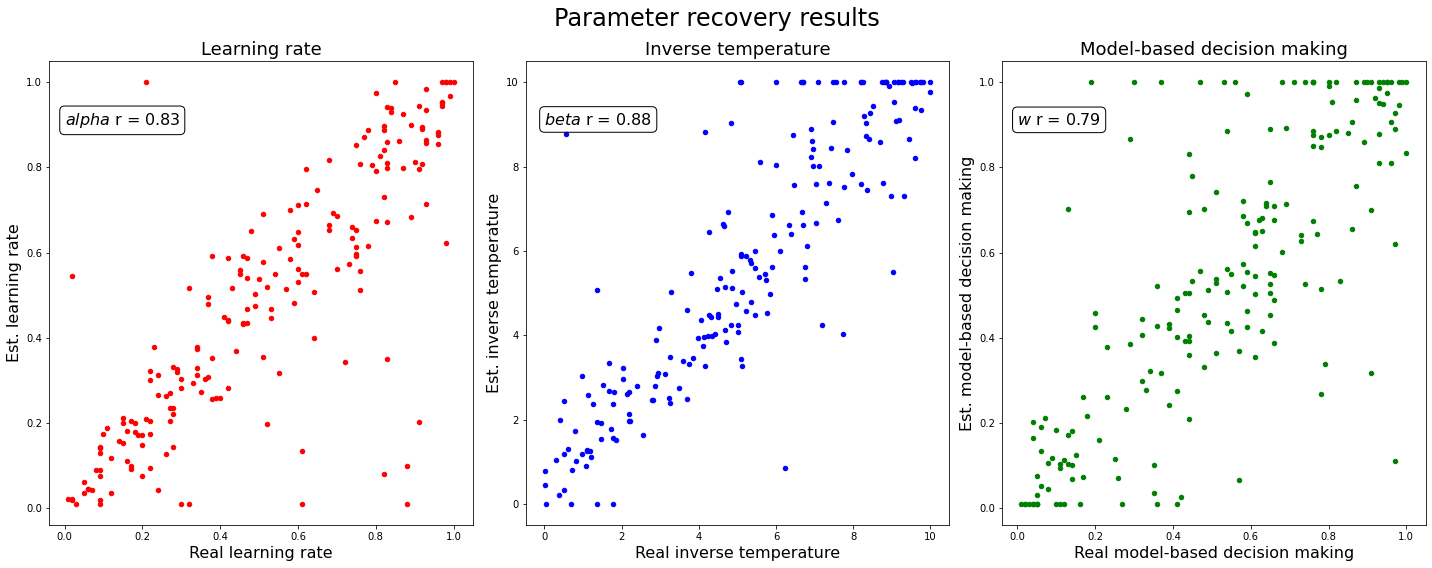

In [15]:
# plot scatterplots of this
fig, ax = plt.subplots(1,3, figsize=(20,8))

# get correlations
lrs_corr, _ = pearsonr(Param_recov['real_alpha'].values, Param_recov['est_alpha'].values)
bs_corr, _ = pearsonr(Param_recov['real_beta'].values, Param_recov['est_beta'].values)
ws_corr, _ = pearsonr(Param_recov['real_w'].values, Param_recov['est_w'].values)

# round r to 2 decimals
lrs_corr_s = round(lrs_corr,2)
bs_corr_s = round(bs_corr,2)
ws_corr_s = round(ws_corr,2)

# plot learning rate
Param_recov.plot(x = "real_alpha", y = "est_alpha" ,kind="scatter", ax=ax[0], 
                xlabel="real alpha", ylabel ="estimated alpha", color= "r")

# text bubble with correlation 
ax[0].text(0,0.9, f'$alpha$ r = {lrs_corr_s}', color = 'black', size=16,
       bbox=dict(facecolor='none', edgecolor='black', boxstyle = 'round'))

# plot inverse temperature
Param_recov.plot(x = "real_beta", y = "est_beta", kind="scatter", ax=ax[1],
                xlabel="real beta", ylabel ="estimated beta", color= "b")

# text bubble with correlation 
ax[1].text(0,9, f'$beta$ r = {bs_corr_s}', color = 'black', size=16,
       bbox=dict(facecolor='none', edgecolor='black', boxstyle = 'round'))

# plot model-based decision making
Param_recov.plot(x = "real_w", y = "est_w" ,kind="scatter", ax=ax[2],
                xlabel="real w", ylabel ="estimated w", color = "g")

# text bubble with correlation 
ax[2].text(0,0.9, f'$w$ r = {ws_corr_s}', color = 'black', size=16,
       bbox=dict(facecolor='none', edgecolor='black', boxstyle = 'round'))


fig.suptitle('Parameter recovery results', size = 24)
ax[0].set_title("Learning rate", size = 18)
ax[1].set_title("Inverse temperature", size = 18)
ax[2].set_title("Model-based decision making", size = 18)
ax[0].set_xlabel("Real learning rate", size = 16)
ax[1].set_xlabel("Real inverse temperature", size = 16)
ax[2].set_xlabel("Real model-based decision making", size = 16)
ax[0].set_ylabel("Est. learning rate", size = 16)
ax[1].set_ylabel("Est. inverse temperature", size = 16)
ax[2].set_ylabel("Est. model-based decision making", size = 16)
plt.tight_layout()


If everything worked out well, this shouldn't look too bad at all. Pretty neat right?

The correlation strength _r_ is plotted as a text bubble for each parameter. Generally, you would expect strong correlations for these types of analyses (for example, r > 0.6). What values do you get out?
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Conclusion

You have made it to the end of this workshop. Congratulations! Thanks for sticking with us, we hope you learned a lot. Please let us know if you have any feedback, so we can improve this workshop!

![Jlo_clap](https://media.giphy.com/media/fnK0jeA8vIh2QLq3IZ/giphy.gif?cid=ecf05e4775ki51jbkrhdf8wduwauofz4e83wk3lz0x94mrbs&rid=giphy.gif&ct=g)

<br>
Before we say goodbye, here are a few things to keep in mind about how to go forward with model-fitting in general, and fitting data for this type in particular. 

Because we wanted to make this an accessible workshop, we have really oversimplified a lot of the code used to simulate behavior and to fit the data. When we fit these models, we include parameter values that account for a host of other things, such as participants being prone to hit the same key regardless of the outcomes in the task, and we also may include free parameters for future reward discounting and the decay of the eligibility of prior actions for current updates, as we briefly talked about in Step 1 of the workshop.

Moreover, a lot of computational modelers have stopped to find the maximum likelihood, but rather the maximum _posterior probabiity_. Derived from Bayes theorem, this probability does not just reflect the likelihood of the data under a model but also the probability of that model per se. We have found that this provides superior fits to data.

So as a cautionary warning, it is good to keep in mind that for best practices of computational modeling of behavioral data, some more work is involved. To keep things simple in the workshop today we therefore had to cut some corners. We believe that this was most likely to benefit you, especially if you were unfamiliar with computational modeling. However, this also means that if you think this kind of work is for you, there is still a lot to learn. We hope you are excited about that! 

A good way to start would be to watch David Silver's introduction to reinforcement learning (https://www.youtube.com/watch?v=2pWv7GOvuf0link link also in Step 1 script), where he goes over the basics of reinforcement learning. 

Additionally, the paper "Ten Simple rules for the computational modeling of behavioral data" by Rober Wilson and Anne Collins is a great overview of good practices for computational modeling: https://elifesciences.org/articles/49547

We hope you enjoyed the workshop and it was our goal to show you that, even though this stuff seems daunting from the outset, understanding is often just few headscratches away.
